<a href="https://colab.research.google.com/github/HakimFerchichi/ChessGame/blob/main/chessModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using Deep Learning to train a Deep Search Chess Algorithm**
**and understanding how neural networks can be used to indirectly solve problems**

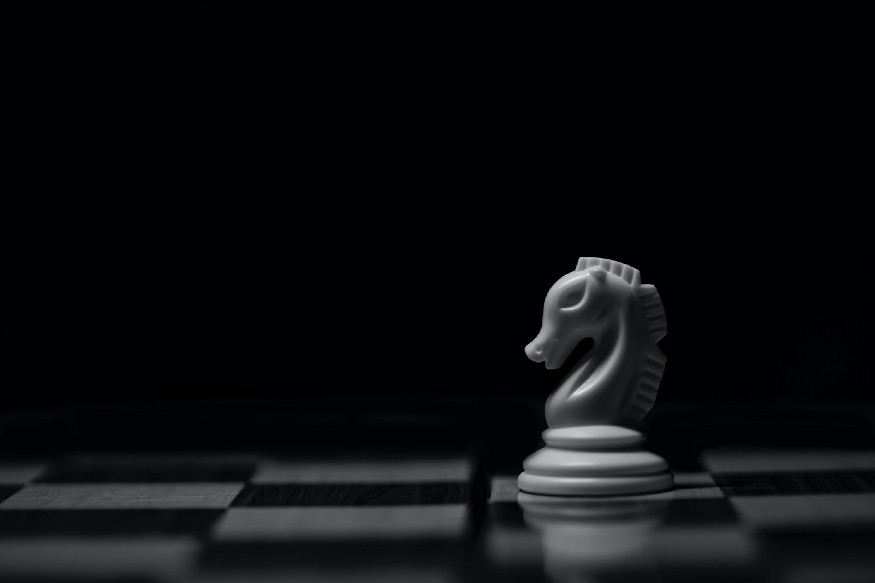

In most chess engines, a searching algorithm along with a heuristic function gives the chess AI the main insight into the best moves to play. The bulk of the programming and most of the “brains” behind this is the heuristic function.
What do I mean by heuristic function? Heuristic function refers to a function that takes certain measurements of the chessboard, gives each measurement a certain weightage, and finally calculate a numerical value of the advantage of each player. The heuristic function in chess usually considers basic things such as pawn structure, center control, and King safety, but it can also include more complex calculations such as tempo and opportunities to employ different tactics.
A well-seasoned chess player with a decent proficiency in programming would be able to construct a good heuristic function. Unfortunately, I am not that well-seasoned chess player. I have decided to use a neural network to create a heuristic function for me.

**Concept:**

The concept of the program uses a neural network to evaluate the board, which is then fitted with the search algorithm, which checks all future position and finds the highest value, sort of like a min-max tree.

In [ ]:
#Step 1- Accessing the Data:
from pandas import read_csv
import numpy as np
import chess
import os
df = read_csv('C:\\Users\\v_sim\\Desktop\\Files\\Data\\chess.csv')
df = df[df['winner']!='draw']
moves = df['moves'].values[:100]
winner = df['winner'].values
X = []
y = []

This script extracts the csv file from my computer, and imports the necessary imports for the program to function. Pandas is for csv data extraction, numpy for the manipulation of arrays, chess for a ready-made chess board and empty lists to represent the X and y values for the network.

In [ ]:
#Step 2- Data prerequisites:
def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

This script is able to transform the class board into a one-hot encoded chessboard. This is done by first accessing the epd form of the board, then splitting it into rows, and finally translating all the squares using a dictionary.

In [ ]:
#Step 3- Create Dataset:
for game in moves:
    index = list(moves).index(game)
    all_moves = game.split()
    total_moves = len(all_moves)
    if winner[index] == 'black':
        game_winner = -1
    else:
        game_winner = 1
    board = chess.Board()
    for i in range(len(all_moves)):
        board.push_san(all_moves[i])
        value = game_winner * (i/total_moves)
        matrix = make_matrix(board.copy())
        rows = translate(matrix,chess_dict)
        X.append([rows])
        y.append(value)
X = np.array(X).reshape(len(X),8,8,12)
y = np.array(y)
X.shape

Believe it or not, this is where all of the magic happens. Instead of using pawn structure and development to calculate the advantage of a player, the neural network will skip directly ahead to checkmates.
The dataset that I have loaded up includes over 14,000 games of chess, giving detailed information on the openings and the moves played. The data that I will synthesize for the network will try and calculate the heuristic value, by learning the value “How many more moves until checkmate for player X?”. It learns this pattern through the thousands of games until it has a strong grasp of the player’s advantage.

In [ ]:
#Step 4- Initialize Neural Network:
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=24, kernel_size=1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'tanh'))

model.predict(X)

This is a basic convolutional neural network, apart from the use of the hyperbolic tangent at the end of the forward propagation loop. The hyperbolic tangent is used in this case, as the values that are attributed to each board can be between -1 and 1, which perfectly fits the range of the hyperbolic tangent.

In [ ]:
#Step 5- Training the network:
from matplotlib import pyplot as plt
model.compile(optimizer='Nadam', loss='mse')
dirx = 'C:\\Users\\v_sim\\Desktop\\Files\\Programs\\ML\\Best Models'
os.chdir(dirx)
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
history = model.fit(X,y,epochs = 1000,verbose = 2,callbacks = callback)
plt.plot(history.history['loss'])

This is the simple training setup for machine learning with sequential keras models.

In [ ]:
#Step 6- Observe Evaluations:
randint = np.random.randint(1,len(moves))
randint2 = np.random.randint(1,len(moves[randint].split()))
board = chess.Board()
for i in range(randint2):
    board.push_san(moves[randint].split()[i])
matrix = make_matrix(board.copy())
rows = translate(matrix,chess_dict)
print('Board Evaluation:',model.predict([rows])[0][0])
board

This step is optional, it is just to see if the evaluations of your network are logical. When the neural network is trained with the above training parameters

In [ ]:
#Step 7- Deep Search Algorithm:
import chess
flatten = lambda l: [item for sublist in l for item in sublist]
def search_positions(board,depth):
    #legal_moves = str(boards[depth][board].legal_moves)[38:-2].replace(',','').split()
    depth_list = []
    for i in range(depth+1):
        depth_list.append([])
    depth_list[0].append(board)
    for layer in depth_list:
        layer_set = []
        try:
            stet = flatten(layer)
        except:
            stet = layer
        for i in range(len(stet)):
            legal_moves = str(stet[i].legal_moves)[38:-2].replace(',','').split()
            legal_moveset = []
            for move in legal_moves:
                neo_board = stet[i].copy()
                neo_board.push_san(move)
                legal_moveset.append(neo_board)
            layer_set.append(legal_moveset)
        if depth_list.index(layer)+1 == len(depth_list):
            break
        depth_list[depth_list.index(layer)+1] = layer_set
    return depth_list
    
boards = search_positions(chess.Board(),2)

I won’t go into too much depth into how my deep search algorithm works, but it simply just uses the legal moves from the python-chess library and basic list functions to create a tree of possible moves.
As I am only using a depth of 2, I only need to evaluate the last set of moves. When considering the worst case scenario for each move, check which one has the best worst case scenario, that is therefore the best move in this circumstance.
In order to evaluate the board without using other complex iterator tools, I came up with an interesting application of the “try: , except:” structure that indexes itself into the next list, until a chess board is found:

In [ ]:
def evaluate(lst):
    for i in range(len(lst)):
        try:
            matrix = make_matrix(lst[i])
            rows = translate(matrix,chess_dict)
            lst[i] = model.predict([rows])
        except:
            evaluate(lst[i])
    return lst
evaluation = evaluate(boards[-1])

Cool right?

In [ ]:
maximum = 0
for term in evaluation:
    if np.mean(term) > maximum:
        maximum = np.mean(term)
        index = evaluation.index(term)

**Conclusion:**

I think that this program is an interesting case, where neural networks are not the ultimate solving factor, but a stepping stone to the final solution of the machine learning problem. I believe that people underestimate neural networks’ ability to bypass complex intermediary obstacles, that prevent one from reaching the goal.

I hope that more people will use Neural networks as the intermediate step in more complicated projects.